In [1]:
from DataFolder import DataFolder
from Signal import Signal

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import emd

from bycycle.features import compute_features

# Configuration

In [2]:
INPUT_DIR = "/home/miranjo/common-datasets/LFP_CBD/rem/"

# Filter settings
f_theta = (4, 12)
f_lowpass = 25
n_seconds_filter = .5  # could be changed to 0.1
n_seconds_theta = .75
fs = 2500

#Bycycle threshold settings
threshold_kwargs = {'amp_fraction_threshold': 0.8,
                        'amp_consistency_threshold': 0,
                        'period_consistency_threshold': 0,
                        'monotonicity_threshold': 0,
                        'min_n_cycles': 8}

# Setting up

In [3]:
def compute_range(x):
    return x.max() - x.min()

def asc2desc(x):
    """Ascending to Descending ratio ( A / A+D )."""
    pt = emd.cycles.cf_peak_sample(x, interp=True)
    tt = emd.cycles.cf_trough_sample(x, interp=True)
    if (pt is None) or (tt is None):
        return np.nan
    asc = pt + (len(x) - tt)
    desc = tt - pt
    return asc / len(x)

def peak2trough(x):
    """Peak to trough ratio ( P / P+T )."""
    des = emd.cycles.cf_descending_zero_sample(x, interp=True)
    if des is None:
        return np.nan
    return des / len(x)


In [4]:
remFolder = DataFolder(INPUT_DIR)
print(remFolder)

DataFolder in '/home/miranjo/common-datasets/LFP_CBD/rem/', contains 102 files.


In [5]:
sample = remFolder[3]
lfpREM = sample["data"][0]
metadata = sample["metadata"]

# Single signal analysis

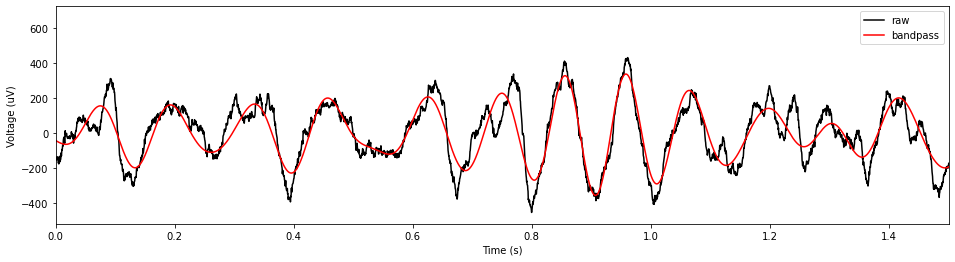

Sampling rate: 2500 Hz
Duration: 122.20 seconds
Max value: 665.82 uV
Min value: -461.92 uV
Mean value: -0.00 uV
Standard Deviation: 159.80 uV
Signal Range: 1127.73 uV
Number of Data Points: 305495


In [6]:
sig = Signal(lfpREM, fs)
sig.filter('bandpass', f_theta, n_seconds_theta)
sig.plot(xlim=(0, 1.5))
sig.summary()

In [7]:
metadata

{'RatID': 'Rat4',
 'StudyDay': 'SD9',
 'condition': 'HC',
 'condition_full': 'HomeCage',
 'treatment': 'TreatmentNegative',
 'posstrial_number': 'posttrial3'}

## Cycle-by-Cycle analysis

### We first detect phasic and tonic periods from the signal

In [8]:
# Detect phasic and tonic periods
df_byc = compute_features(sig.filtered, fs, f_range=f_theta, threshold_kwargs=threshold_kwargs, center_extrema='peak')

#Extract Phasic and Tonic states
df_theta_phasic = df_byc[df_byc['is_burst']]
df_theta_tonic  = df_byc[df_byc['is_burst' ] == False]

result_msg = "{} periods in the {} signal: {}"

print(result_msg.format("Phasic", sig.filter_type, len(df_theta_phasic)))
print(result_msg.format("Tonic", sig.filter_type, len(df_theta_tonic)))


df_byc_2 = compute_features(sig.raw_signal, fs, f_range=f_theta, threshold_kwargs=threshold_kwargs, center_extrema='peak')
phasic_raw = len( df_byc_2[df_byc_2['is_burst']])
tonic_raw = len(df_byc_2[df_byc_2['is_burst' ] == False])

print(result_msg.format("Phasic", "raw", phasic_raw))
print(result_msg.format("Tonic", "raw", tonic_raw))


Phasic periods in the bandpass signal: 47
Tonic periods in the bandpass signal: 865
Phasic periods in the raw signal: 20
Tonic periods in the raw signal: 893


In [9]:
# Peak to Trough ratio for Bycyle Cycle
p = df_theta_phasic.time_peak
t = df_theta_phasic.time_trough
p2t_phasic = p/(p+t)

# Peak to Trough ratio for Bycyle Cycle
p = df_theta_tonic.time_peak
t = df_theta_tonic.time_trough
p2t_tonic = p/(p+t)

# Ascending to Descending ratio for Bycyle Cycle
A = df_theta_phasic.time_rise
D = df_theta_phasic.time_decay
asc2desc_phasic = A/(A+D)

# Ascending to Descending ratio for Bycyle Cycle
A = df_theta_tonic.time_rise
D = df_theta_tonic.time_decay
asc2desc_tonic = A/(A+D)

In [10]:
def plot_hist(feature, bins='auto', ax=None, density=False, **kwargs):

    # Default keyword args
    figsize = kwargs.pop('figsize', (5, 5))
    xlabel = kwargs.pop('xlabel', None)
    xlim = kwargs.pop('xlim', None)
    ylim = kwargs.pop('ylim', None)
    fontsize = kwargs.pop('fontsize', 15)
    alpha = kwargs.pop('alpha', .7)

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # Axis style
    ax.set_xlabel(xlabel, size=fontsize)

    if density:
        ax.set_ylabel('Cycles density', size=fontsize)
    else:
        ax.set_ylabel('Number of cycles', size=fontsize)

    if xlim is not None:
        ax.set_xlim(xlim)

    if ylim is not None:
        ax.set_xlim(ylim)
        
    ax.hist(feature, bins=bins, alpha=alpha, density=density, **kwargs)

## Phasic vs Tonic features histogram

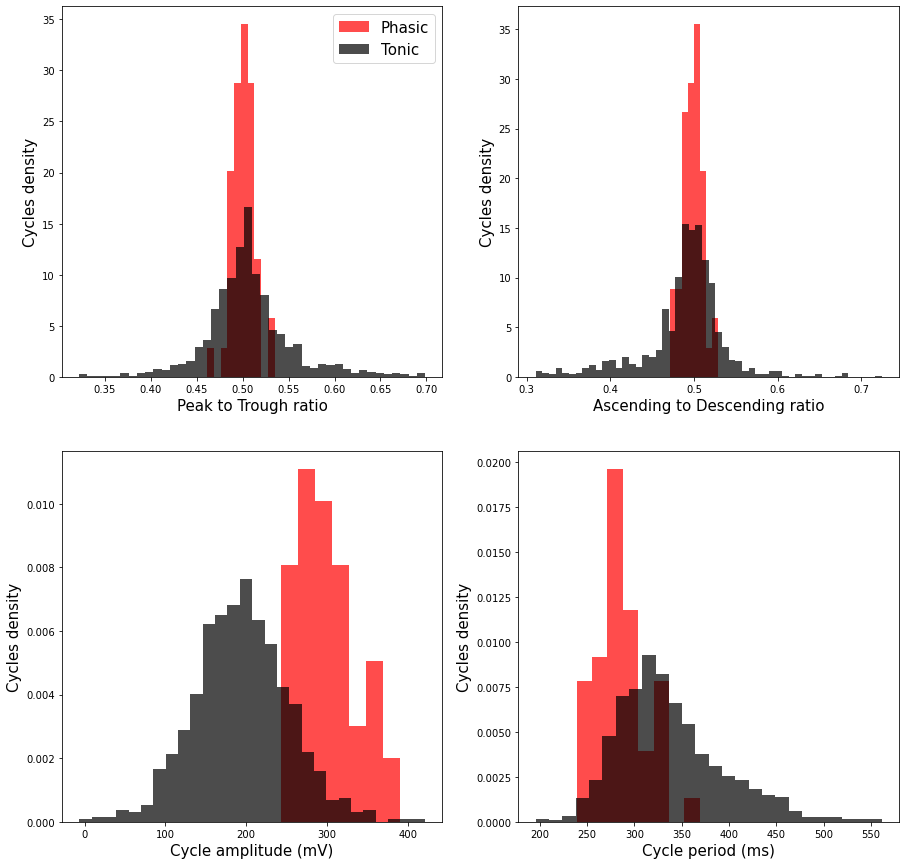

In [11]:
fig, axes = plt.subplots(figsize=(15, 15), nrows=2, ncols=2)

# Peak to trough ratio
dist1 = p2t_phasic
dist2 = p2t_tonic

plot_hist(dist1, ax=axes[0][0], density=True, xlabel="Peak to Trough ratio", color='r')
plot_hist(dist2, ax=axes[0][0], density=True, xlabel="Peak to Trough ratio", color='k')

axes[0][0].legend(['Phasic', 'Tonic'], fontsize=15)

# Ascending to descending ratio
dist1 = asc2desc_phasic
dist2 = asc2desc_tonic

plot_hist(dist1, ax=axes[0][1], density=True, xlabel="Ascending to Descending ratio", color='r')
plot_hist(dist2, ax=axes[0][1], density=True, xlabel="Ascending to Descending ratio", color='k')

# Max amplitude
dist1 = df_theta_phasic['volt_peak']
dist2 = df_theta_tonic['volt_peak']

plot_hist(dist1, ax=axes[1][0], density=True, xlabel="Cycle amplitude (mV)", color='r')
plot_hist(dist2, ax=axes[1][0], density=True, xlabel="Cycle amplitude (mV)", color='k')

# Duration of samples
dist1 = df_theta_phasic['time_rise'] + df_theta_phasic['time_decay']
dist2 = df_theta_tonic['time_rise'] + df_theta_tonic['time_decay']

plot_hist(dist1, ax=axes[1][1], density=True, xlabel="Cycle period (ms)", color='r')
plot_hist(dist2, ax=axes[1][1], density=True, xlabel="Cycle period (ms)", color='k')

## EMD analysis

In [12]:
IP, IF, IA = emd.spectra.frequency_transform(sig.filtered, fs, 'hilbert', smooth_phase=3)

C = emd.cycles.Cycles(IP.flatten())
print("Detected cycles before extraction:")
print(C)

# computing the cycle metrics 
C.compute_cycle_metric('start_sample', np.arange(len(C.cycle_vect)), emd.cycles.cf_start_value)
C.compute_cycle_metric('stop_sample', sig.filtered, emd.cycles.cf_end_value)
C.compute_cycle_metric('peak_sample', sig.filtered, emd.cycles.cf_peak_sample)
C.compute_cycle_metric('desc_sample', sig.filtered, emd.cycles.cf_descending_zero_sample)
C.compute_cycle_metric('trough_sample', sig.filtered, emd.cycles.cf_trough_sample)
C.compute_cycle_metric('duration_samples', sig.filtered, len)

C.compute_cycle_metric('max_amp', IA, np.max)
C.compute_cycle_metric('mean_if', IF, np.mean)
C.compute_cycle_metric('max_if', IF, np.max)
C.compute_cycle_metric('range_if', IF, compute_range)

C.compute_cycle_metric('asc2desc', sig.filtered, asc2desc)
C.compute_cycle_metric('peak2trough', sig.filtered, peak2trough)

print('\nFinished computing the cycles metrics\n')

# Extract subset of the cycles 
amp_thresh = np.percentile(IA, 25)
lo_freq_duration = fs/5
hi_freq_duration = fs/12
conditions = ['is_good==1',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'max_amp>{amp_thresh}']

print("Cycles after extraction:")
df_emd = C.get_metric_dataframe(conditions=conditions)
print(f'{len(df_emd)}')

Detected cycles before extraction:
<class 'emd.cycles.Cycles'> (913 cycles 1 metrics) 

Finished computing the cycles metrics

Cycles after extraction:
838


In [13]:
df_emd

,index,is_good,start_sample,stop_sample,peak_sample,desc_sample,trough_sample,duration_samples,max_amp,mean_if,max_if,range_if,asc2desc,peak2trough
0,1,1,102,-0.833156,85.248573,154.228228,231.148985,309,198.939084,8.102122,8.306203,0.931978,0.527830,0.499120
1,2,1,411,-1.407481,70.662014,157.199199,242.182411,332,188.772912,7.520719,8.009581,1.050018,0.483372,0.473492
2,3,1,743,-2.755998,92.056632,164.675676,246.467745,325,232.916431,7.692152,7.848703,0.694283,0.524889,0.506694
3,4,1,1068,-2.414284,74.361087,173.485485,332.551082,409,229.232140,6.109849,7.719058,3.858917,0.368729,0.424170
4,5,1,1477,-4.141983,86.533143,164.422422,244.23872,322,217.047615,7.759397,8.251989,1.084843,0.510231,0.510629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,906,1,302698,-0.619264,103.203811,223.492492,368.538581,465,196.240389,5.374887,6.258309,1.680801,0.429388,0.480629
834,907,1,303163,-0.827719,96.31599,187.123123,273.120151,371,218.736623,6.737225,6.850677,0.585315,0.523439,0.504375
835,908,1,303534,-1.674010,88.882003,176.633634,260.736279,345,163.299226,7.240469,7.534917,0.734507,0.501872,0.511982
836,909,1,303879,-2.333841,94.448266,188.984985,285.494144,366,247.173720,6.832369,7.507808,1.163205,0.478017,0.516352


In [14]:
df_byc = compute_features(sig.filtered, fs, f_range=f_theta, threshold_kwargs=threshold_kwargs, center_extrema='peak')

#Extract Phasic and Tonic states
df_theta_phasic = df_byc[df_byc['is_burst']]
df_theta_tonic  = df_byc[df_byc['is_burst' ] == False]

## EMD vs Cycle by Cycle feature histogram

In [15]:
# Peak to Trough ratio for Bycyle Cycle
p = df_byc.time_peak
t = df_byc.time_trough
p2t = p/(p+t)

# Ascending to Descending ratio for Bycyle Cycle
A = df_byc.time_rise
D = df_byc.time_decay
asc2desc = A/(A+D)

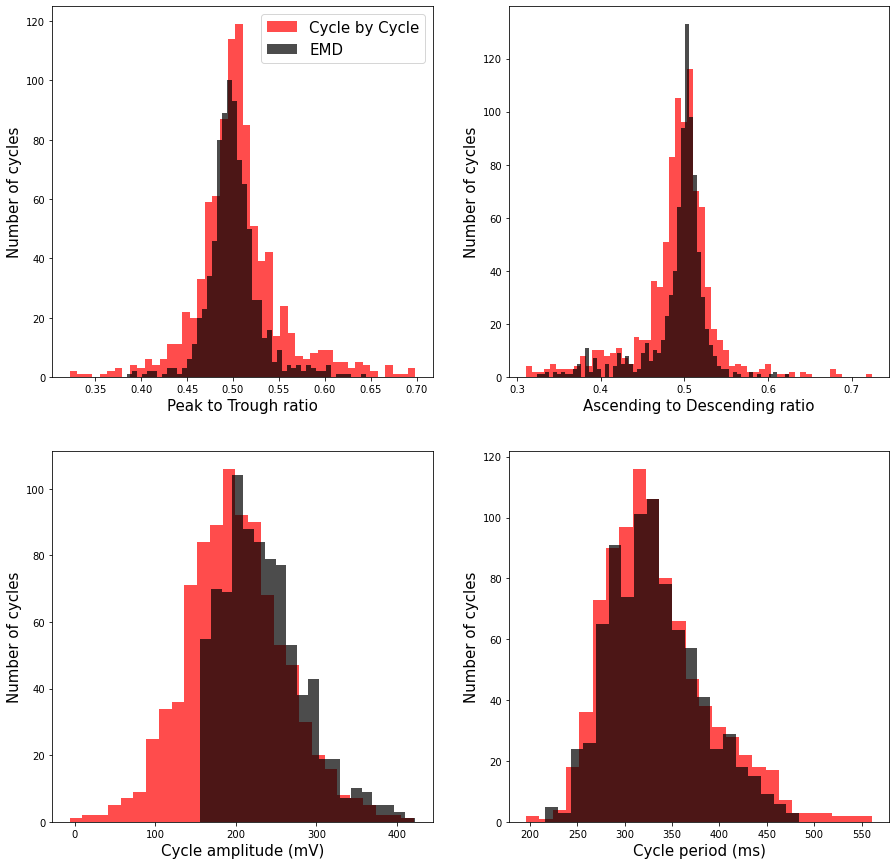

In [16]:
fig, axes = plt.subplots(figsize=(15, 15), nrows=2, ncols=2)

# Peak to trough ratio
dist1 = p2t
dist2 = df_emd['peak2trough']

plot_hist(dist1, ax=axes[0][0], xlabel="Peak to Trough ratio", color='r')
plot_hist(dist2, ax=axes[0][0], xlabel="Peak to Trough ratio", color='k')

axes[0][0].legend(['Cycle by Cycle', 'EMD'], fontsize=15)

# Ascending to descending ratio
dist1 = asc2desc
dist2 = df_emd['asc2desc']

plot_hist(dist1, ax=axes[0][1], xlabel="Ascending to Descending ratio", color='r')
plot_hist(dist2, ax=axes[0][1], xlabel="Ascending to Descending ratio", color='k')

# Max amplitude
dist1 = df_byc['volt_peak']
dist2 = df_emd['max_amp']

plot_hist(dist1, ax=axes[1][0], xlabel="Cycle amplitude (mV)", color='r')
plot_hist(dist2, ax=axes[1][0], xlabel="Cycle amplitude (mV)", color='k')

# Duration of samples
dist1 = df_byc['time_rise'] + df_byc['time_decay']
dist2 = df_emd['duration_samples']

plot_hist(dist1, ax=axes[1][1], xlabel="Cycle period (ms)", color='r')
plot_hist(dist2, ax=axes[1][1], xlabel="Cycle period (ms)", color='k')

# Running the analysis on all dataset

In [17]:
#from neurodsp.filt import filter_signal
#
#bins = np.arange(0, 0.05, 1)
#
#for rem in remFolder:
#    for sig in rem["data"]:
#        sig_filt = filter_signal(sig, fs, "bandpass", f_theta, n_seconds=n_seconds_theta, remove_edges=False)
#        df = compute_features(sig_filt, fs, f_range=f_theta, threshold_kwargs=threshold_kwargs, center_extrema='peak')
#
#        # Extract Phasic and Tonic states
#        df_theta_phasic = df_byc[df_byc['is_burst']]
#        df_theta_tonic  = df_byc[df_byc['is_burst' ] == False]
#
#        # Calculations
#        # np.histogram(df_theta_phasic['volt_peak'], bins)
#        pass

# Extracting phasic and tonic from the signal

In [18]:
def segment(timestamps, signal):

    inds = timestamps.index.to_list()

    # Extract pairs of start and end points
    pairs = []
    start = inds[0]

    for i in range(1, len(inds), 1):
        if (inds[i] != inds[i-1] + 1  ):
            end = inds[i-1]
            if start != end:
                pairs.append((start, end))
            start = inds[i]
    if start != inds[-1]:
        pairs.append((start, inds[-1]))

    # Extract the signal
    samples = []
    for pair in pairs:
        samples.append((timestamps.loc[pair[0]]["sample_last_trough"], timestamps.loc[pair[1]]["sample_next_trough"]))
    
    segmented_signals = []

    for pair in samples:
        start, end = pair
        segment = signal[start:end]
        segmented_signals.append(segment)

    return segmented_signals

In [19]:
# Phasic segments
timestamps = df_theta_phasic[["sample_last_trough", 'sample_next_trough']]
phasic = segment(timestamps, sig.filtered)
phasic

[array([-261.32080307, -261.3061409 , -261.14862865, ..., -266.59216283,
        -266.82767259, -266.96198792]),
 array([-238.02369128, -237.90757863, -237.66788851, ..., -218.8244056 ,
        -219.07389816, -219.23895495]),
 array([-245.66030786, -245.58695806, -245.42420651, ..., -258.0211653 ,
        -258.28563174, -258.41869292]),
 array([-250.51924292, -250.42085736, -250.20833721, ..., -324.18216036,
        -324.68330921, -324.99453391]),
 array([-191.5109722 , -191.3622228 , -191.04729905, ..., -235.25041072,
        -235.52425923, -235.68866423])]

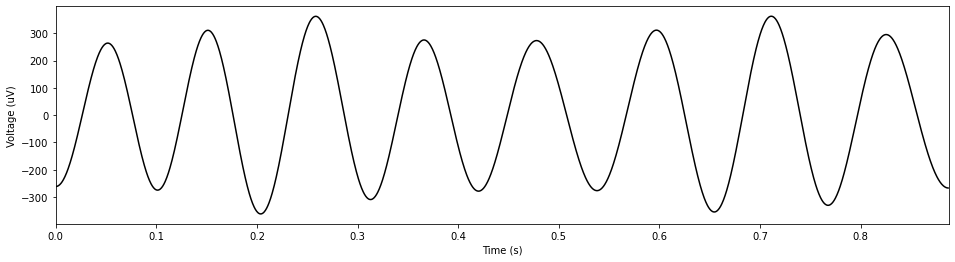

In [20]:
phasic1 = Signal(phasic[0], fs)
phasic1.plot()

In [21]:
[len(s) for s in phasic]

[2218, 2542, 3100, 2522, 3057]

In [ ]:
def emd_analysis(signal, fs):
    IP, IF, IA = emd.spectra.frequency_transform(signal, fs, 'hilbert', smooth_phase=3)

    C = emd.cycles.Cycles(IP.flatten())
    print("Detected cycles before extraction:")
    print(C)

    # computing the cycle metrics 
    C.compute_cycle_metric('start_sample', np.arange(len(C.cycle_vect)), emd.cycles.cf_start_value)
    C.compute_cycle_metric('stop_sample', signal, emd.cycles.cf_end_value)
    C.compute_cycle_metric('peak_sample', signal, emd.cycles.cf_peak_sample)
    C.compute_cycle_metric('desc_sample', signal, emd.cycles.cf_descending_zero_sample)
    C.compute_cycle_metric('trough_sample', signal, emd.cycles.cf_trough_sample)
    C.compute_cycle_metric('duration_samples', signal, len)

    C.compute_cycle_metric('max_amp', IA, np.max)
    C.compute_cycle_metric('mean_if', IF, np.mean)
    C.compute_cycle_metric('max_if', IF, np.max)
    C.compute_cycle_metric('range_if', IF, compute_range)

    C.compute_cycle_metric('asc2desc', signal, asc2desc)
    C.compute_cycle_metric('peak2trough', signal, peak2trough)

    print('\nFinished computing the cycles metrics\n')

    # Extract subset of the cycles 
    amp_thresh = np.percentile(IA, 25)
    lo_freq_duration = fs/5
    hi_freq_duration = fs/12
    conditions = ['is_good==1',
                  f'duration_samples<{lo_freq_duration}',
                  f'duration_samples>{hi_freq_duration}',
                  f'max_amp>{amp_thresh}']

    print("Cycles after extraction:")
    df_emd = C.get_metric_dataframe(conditions=conditions)
    print(f'{len(df_emd)}')
    return df_emd

Detected cycles before extraction:
<class 'emd.cycles.Cycles'> (9 cycles 1 metrics) 


TypeError: 'Series' object is not callable

In [22]:
df = []
for ph in phasic:
    df.append(emd_analysis(ph, fs))

NameError: name 'emd_analysis' is not defined